In [72]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [73]:
import numpy as np
import pandas as pd
import datetime


# Reflect Tables into SQLAlchemy ORM

In [74]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text


In [75]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [76]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [77]:
# Print all of the classes mapped to the Base
print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.measurement'>, <class 'sqlalchemy.ext.automap.station'>]


In [78]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [79]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [84]:
# Design a query to calculate the total number of stations in the dataset
query = "SELECT count(id) from station"

with engine.connect() as conn:
    print(conn.execute(text(query)).fetchall())

[(9,)]


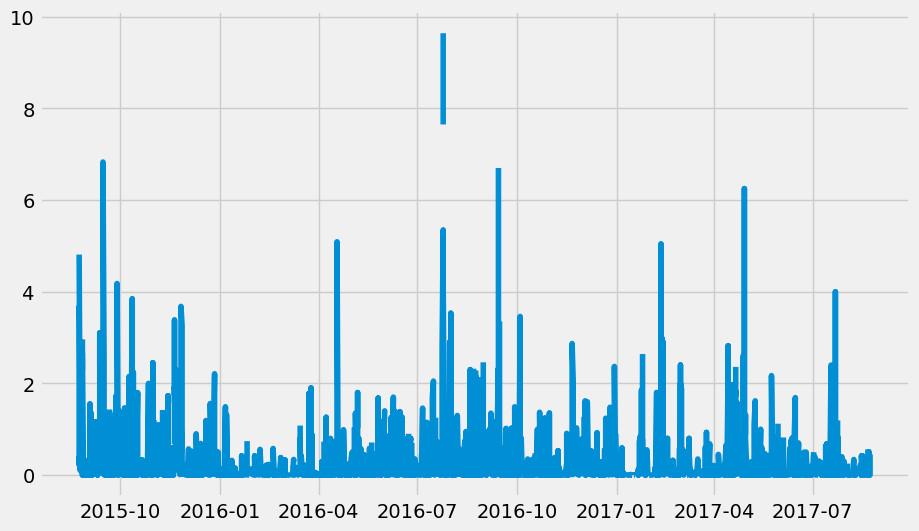

In [89]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = datetime.date(2016, 8, 23) - datetime.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_sq = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= most_recent_date).\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_sq, columns=["Date", "Precipitation"])

# Sort the dataframe by date
precipitation_df["Date"] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values(by="Date", ascending=True).reset_index(drop=True)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(precipitation_df.Date, precipitation_df.Precipitation)
plt.show()

In [90]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.Precipitation.describe()

count    4091.000000
mean        0.205634
std         0.529369
min         0.000000
25%         0.000000
50%         0.020000
75%         0.160000
max         9.640000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [92]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(total_stations)

9


In [93]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
print(most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [94]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
     filter(Measurement.station == most_active_station).all()
print(temp_stats)

[(54.0, 85.0, 71.66378066378067)]


In [95]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= most_recent_date).all()

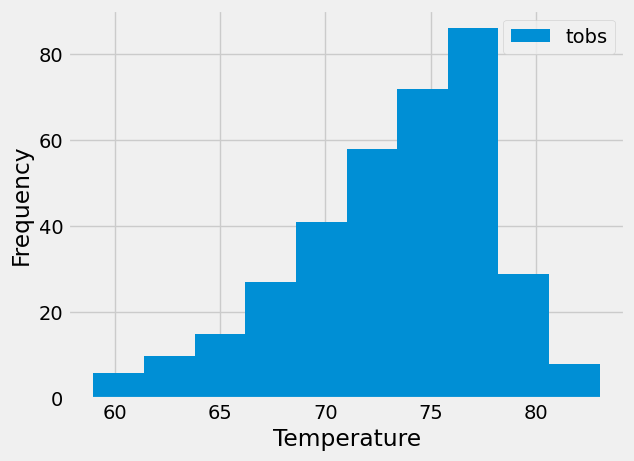

In [96]:
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and tobs scores
most_recent_date = datetime.date(2017, 8, 23) - datetime.timedelta(days=365)

# Sort the dataframe by date
tobs_results = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= most_recent_date).all()
# Plotting the results as a histogram
tobs_df = pd.DataFrame(tobs_results, columns=['tobs'])
tobs_df.plot.hist(bins=10)
plt.xlabel("Temperature")
plt.show()

# Close Session

In [97]:
# Close Session
session.close()
